# Galactic extinction correction

Part of the light emitted by the observed object is absorbed by the interstellar dust of the Milky Way. This notebook corrects this defect, taking into account the galactic coordinates of the observed object.

In [3]:
import json
import astropy.coordinates
import astropy.time
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from dust_extinction.parameter_averages import G23

The galactic coordinates can be used to query on NED (NASA/IPAC Extragalactic Database) for the extinction parameters. The cell below gathers this information from the FITS headers

In [4]:
with open("sci_files_object_mapping.json", "r") as f:
    sci_files_object_mapping = json.load(f)


def get_galactic_coord(filename):
    with fits.open(filename) as hdul:
        header = hdul[0].header

    coord = astropy.coordinates.TETE(
        ra=header["RA"] * u.deg,
        dec=header["DEC"] * u.deg,
        obstime=astropy.time.Time(header["DATE-OBS"]),
    )

    coord = coord.transform_to(astropy.coordinates.Galactic())
    return coord.l.deg, coord.b.deg


galactic_coords = {}
for object_name in sci_files_object_mapping.keys():
    filename = f"redux/cstxeqxbrg{sci_files_object_mapping[object_name][0]}"
    galactic_coords[object_name] = get_galactic_coord(filename)

galactic_coords

{'GSN 069': (266.0380720718457, -80.81866036697947),
 'eRO-QPE2': (259.7776959324085, -63.15783504967886)}

When the object is not widely known (as is the case for eRO-QPE2) we might not find it on NED. We can use nearby objects as proxies, but this might lead to small errors. The code below plots different extinctions curves using varying Rvs from nearby objects in order to visually grasp how much error we might be introducing to the data.

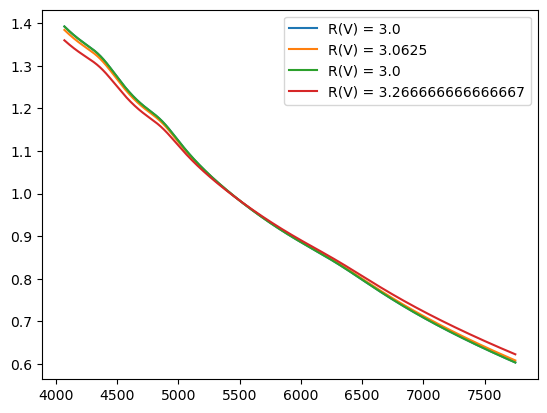

In [9]:
# Visual comparison between extinction curves for slightly different Rvs

object_name = "eRO-QPE2"
name = object_name.replace(" ", "").lower()
filename = f"redux/{name}_combined_spectra.fits"
with fits.open(filename) as hdul:
    input_data = hdul["SCI"].data

fits_header = fits.getheader(filename, ext=("sci", 1))
wcs = WCS(fits_header, naxis=[1])
wavelength = wcs.wcs_pix2world(np.arange(fits_header["NAXIS1"]), 0)[0] * u.AA

fig, ax = plt.subplots()
AB_AV = [
    (0.064, 0.048),
    (0.065, 0.049),
    (0.064, 0.048),
    (0.064, 0.049),
]  # AB and AV for each of the 4 proxies
Rvs = [ext_params[1] / (ext_params[0] - ext_params[1]) for ext_params in AB_AV]
for Rv in Rvs:
    ext_model = G23(Rv=Rv)
    ax.plot(wavelength, ext_model(wavelength), label="R(V) = " + str(Rv))

ax.legend(loc="best")
plt.show()

Seems safe to use the mean values for eRO-QPE2

#### Test corrections

In [10]:
# Define correction function
def unestiguish_spectra(object_name, AB, AV):
    # Load input spectra
    name = object_name.replace(" ", "").lower()
    filename = f"redux/{name}_combined_spectra.fits"
    with fits.open(filename) as hdul:
        input_spectra = hdul["SCI"].data

    # Load wavelength
    fits_header = fits.getheader(filename, ext=("sci", 1))
    wcs = WCS(fits_header, naxis=[1])
    wavelength = wcs.wcs_pix2world(np.arange(fits_header["NAXIS1"]), 0)[0] * u.AA

    u_flux = u.erg / (u.cm**2 * u.s * u.AA)  # define flux unity

    # Calculate Ebv and Rv
    Ebv = AB - AV
    Rv = AV / Ebv

    # Perform correction
    ext_model = G23(Rv)
    correction_factor = ext_model.extinguish(wavelength, Ebv=Ebv)
    unestinguished_spectra = np.zeros(input_spectra.shape)
    for index, spectrum in enumerate(input_spectra):
        flux = spectrum * u_flux
        unestinguished_spectra[index] = flux / correction_factor

    return unestinguished_spectra, input_spectra

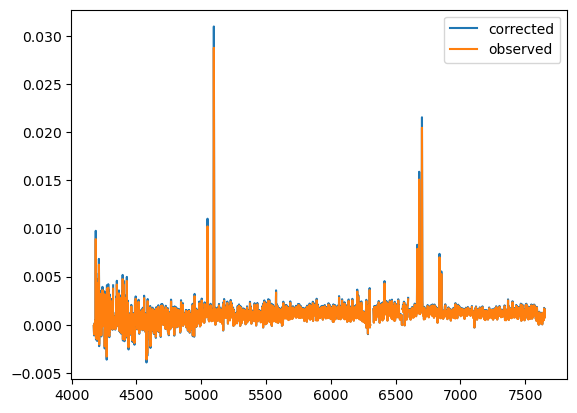

In [12]:
# Visual inspection of corrections
unestinguished_spectra, og_spectra = unestiguish_spectra("GSN 069", 0.098, 0.074)

fiber = 350

plt.plot(wavelength, unestinguished_spectra[fiber], label="corrected")

plt.plot(wavelength, og_spectra[fiber], label="observed")
plt.legend()

#### Perform corrections

In [14]:
# Prepare input parameters for eRO-QPE2
ABs, AVs = zip(*AB_AV)
avg_AB = np.mean(ABs)
avg_AV = np.mean(AVs)

# Organize input data for corrections
input_params = {
    "GSN 069": {"AB": 0.098, "AV": 0.074},
    "eRO-QPE2": {"AB": avg_AB, "AV": avg_AV},
}

{'GSN 069': {'AB': 0.098, 'AV': 0.074},
 'eRO-QPE2': {'AB': 0.06425, 'AV': 0.0485}}

In [16]:
# Run definitive corrections and save new FITS
for object_name in input_params.keys():
    unestinguished_spectra, og_spectra = unestiguish_spectra(
        object_name, input_params[object_name]["AB"], input_params[object_name]["AV"]
    )
    name = object_name.replace(" ", "").lower()

    filename = f"redux/{name}_combined_spectra.fits"

    new_filename = f"redux/{name}_combined_spectra_ext.fits"

    with fits.open(filename) as hdul:

        hdul["SCI"].data = unestinguished_spectra

        hdul.writeto(new_filename, overwrite=True)
        print(f"corrected data saved at: {new_filename}")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


corrected data saved at: redux/gsn069_combined_spectra_ext.fits
corrected data saved at: redux/ero-qpe2_combined_spectra_ext.fits
